## 必要なプログラムパッケージのインストール

まず、Pythonにpyscf, qulacs, openfermion, openfermion-pyscfをインストールする。(qulacsのインストールにはgcc7以上が必要。)
```
pip install pyscf openfermion
pip install openfermionpyscf
pip install qulacs
```

その後JuliaやPyCall.jlの導入。。。。
この他にもscipyやmatplotlibをこのノートでは使用している。

In [1]:
import Revise

In [2]:
import QCMaterial: uccsd1, convert_openfermion_op, up_index, down_index

┌ Info: Precompiling QCMaterial [a9cd9503-f9e9-42c1-955f-178e1ea1d76e]
└ @ Base loading.jl:1260


In [3]:
using PyCall

In [4]:
plt = pyimport("matplotlib.pyplot")
of = pyimport("openfermion")
ofpyscf = pyimport("openfermionpyscf")
qulacs = pyimport("qulacs")
scipy_opt = pyimport("scipy.optimize")
get_fermion_operator = of.transforms.get_fermion_operator
jordan_wigner = of.transforms.jordan_wigner
jw_get_ground_state_at_particle_number = of.linalg.sparse_tools.jw_get_ground_state_at_particle_number
get_number_preserving_sparse_operator = of.linalg.get_number_preserving_sparse_operator
FermionOperator = of.ops.operators.FermionOperator

PyObject <class 'openfermion.ops.operators.fermion_operator.FermionOperator'>

## 2-site Hubbard modelのハミルトニアンを定義する。

$H=-t \sum_{\langle i, j>\sigma=(\uparrow, \downarrow)} \sum_{i, \sigma}\left(a_{i, \sigma}^{\dagger} a_{j, \sigma}+a_{j, \sigma}^{\dagger} a_{i, \sigma}\right)+U \sum_{i} n_{i, \uparrow} n_{i, \downarrow}-\mu \sum_{i} \sum_{\sigma=(\uparrow, \downarrow)} n_{i, \sigma}$

$1_\uparrow$->0,$1_\downarrow$->1, $2_\uparrow$->2, $2_\downarrow$->3

クーロン斥力(U=2): 2 * $n_{1,\uparrow}$ $n_{1,\downarrow}$ + 2 * $n_{2,\uparrow}$ $n_{2,\downarrow}$ 
               = 2 * $c^\dagger_0$ $c_0$ $c^\dagger_1$ $c_1$ + 2 * $c^\dagger_2$ $c_2$ $c^\dagger_3$ $c_3$
 
ホッピング項(t=-0.1): -0.1 * $c^\dagger_{1,\uparrow}$ $c_{2,\uparrow}$ -0.1 * $c^\dagger_{2,\uparrow}$ $c_{1,\uparrow}$
                   -0.1 * $c^\dagger_{1,\downarrow}$ $c_{2,\downarrow}$ -0.1 * $c^\dagger_{2,\downarrow}$ $c_{1,\downarrow}$
  = -0.1 * $c^\dagger_0$ $c_2$ + -0.1 * $c^\dagger_2$ $c_0$ + -0.1 * $c^\dagger_1$ $c_3$ + -0.1 * $c_3^\dagger$ $c_1$

ケミカルポテンシャル項(μ=U/2=1):-1 * $n_{1,\uparrow}$ - 1 * $n_{1,\downarrow}$ - 1 * $n_{2,\uparrow}$ - 1 * $n_{2,\downarrow}$ 
               = - 1 * $c^\dagger_0$ $c_0$ - 1 * $c^\dagger_1$ $c_1$ - 1 * $c^\dagger_2$ $c_2$ - 1 * $c^\dagger_3$ $c_3$

In [43]:
#ハバードモデルハミルトニアンを定義し、対角化まで行う
nsite = 2 #サイトの数
n_qubit = 2*nsite #量子ビットの数
U = 2.0
t = -0.01

#ハーフフィリングを仮定(電子数 = サイトの数)するとケミカルポテンシャルはμ=U/2.マイナスがつくので以下。
μ = U/2

ham = FermionOperator()
#斥力項
for i in 1:nsite
    #up_index,down_indexの定義は、QC_materialを参照。
    up = up_index(i)
    down = down_index(i)
    ham += FermionOperator("$(up)^ $(down)^ $(up) $(down)", -U) #左側に生成演算子。右際に消滅演算子をもっていく過程で半交換関係が1回でマイナスをつける。
end
#ホッピング項
for i in 1:nsite-1
    ham += FermionOperator("$(up_index(i+1))^ $(up_index(i))", t) 
    ham += FermionOperator("$(up_index(i))^ $(up_index(i+1))", t) 
    ham += FermionOperator("$(down_index(i+1))^ $(down_index(i))", t) 
    ham += FermionOperator("$(down_index(i))^ $(down_index(i+1))", t) 
end

#ケミカルポテンシャルの項
for i in 1:nsite
    up = up_index(i)
    down = down_index(i)
    ham += FermionOperator("$(up)^  $(up) ", -μ) 
    ham += FermionOperator("$(down)^ $(down)", -μ)
end

println(ham)　#ハバードモデルハミルトニアンの表示。

n_electron = 2　#電子数。ここではハーフフィリングを仮定しているので、電子数はサイトの数と等しくなければならない。
@assert mod(n_electron, 2) == 0
sparse_mat = get_number_preserving_sparse_operator(ham, n_qubit, n_electron)　#行列の取得

using LinearAlgebra
enes_ed = eigvals(sparse_mat.toarray())　#対角化を行う
enes_ed

PyObject -1.0 [0^ 0] +
-2.0 [0^ 1^ 0 1] +
-0.01 [0^ 2] +
-1.0 [1^ 1] +
-0.01 [1^ 3] +
-0.01 [2^ 0] +
-1.0 [2^ 2] +
-2.0 [2^ 3^ 2 3] +
-0.01 [3^ 1] +
-1.0 [3^ 3]


6-element Array{Float64,1}:
 -2.0001999800039973
 -2.0
 -2.0
 -2.0
  3.263101937807322e-45
  0.00019998000399900045

In [44]:
#最小固有値
EigVal_min = minimum(enes_ed)
EigVal_min

-2.0001999800039973

## Jordan-Wigner展開
2サイトのハバードモデルのハミルトニアンを用意し、スピン系にマッピングする。
ここではJordan-Wigner展開を用いることとする。

In [46]:
#JW変換
jw_hamiltonian = jordan_wigner(ham)

PyObject (-1+0j) [] +
(-0.005+0j) [X0 Z1 X2] +
(-0.005+0j) [Y0 Z1 Y2] +
(0.5+0j) [Z0 Z1] +
(-0.005+0j) [X1 Z2 X3] +
(-0.005+0j) [Y1 Z2 Y3] +
(0.5+0j) [Z2 Z3]

## Qulacsを用いた分子計算の準備
まず、OpenFermionを用いて得たハミルトニアン(jw_hamiltonian)をQulacsで使えるようにする。

In [47]:
#Qulacs用のハミルトニアンの作成
qulacs_hamiltonian = qulacs.observable.create_observable_from_openfermion_text(jw_hamiltonian.__str__())

PyObject <qulacs.Observable object at 0x1534f088eb70>

In [48]:
hfstate(n_qubit, n_electron) = parse(Int, repeat("0", n_qubit-n_electron) * repeat("1", n_electron), base=2)

hfstate (generic function with 1 method)

## Unitary Coupled Cluster (UCC)の概略

Hartree-Fock波動関数を $|\Phi \rangle$ とすると、Unitary Coupled Cluster（UCC)は以下の形で定義される。
$$|\Psi \rangle =e^{\hat{T}-\hat{T}^{\dagger}}|\Phi \rangle$$
これに対して通常のCoupled Cluster（CC）は以下の形を取る。
$$|\Psi \rangle =e^{\hat{T}}|\Phi \rangle$$
最も広く使われるCC or UCCは $\hat{T}$ を1電子励起 $\hat{T}_1$ と2電子励起 $\hat{T}_2$ に限定したCCSD or UCCSDとなっている。
CCSDないしUCCSDの $\hat{T}$ は具体的には次のように定義される。
$$
\hat{T} = \sum_{ai}t^{a}_{i} a^{\dagger}_a a_i + 
1/4\sum_{ab,ij}t^{ab}_{ij} a^{\dagger}_a a^{\dagger}_b a_j a_i
$$ 
ここで添字 $a,b$ は仮想軌道を示し、 $i,j$ は占有軌道を示す。


CCはHamiltonian $\hat{H}$ のsimilarity transformation $e^{-\hat{T}}\hat{H}e^{T}$ のBCH展開が打ち切れるため古典コンピュータで実装可能である。
一方で、UCCは脱励起演算子 $\hat{T}^{\dagger}$ のためにBCH展開が打ちきれず無限に続くために古典コンピュータでは計算不可能であるが、
$e^{\hat{T}-\hat{T}^{\dagger}}$ はユニタリー変換であるため量子回路で記述できる。
ただし、 $e^{\hat{T}-\hat{T}^{\dagger}}$ を量子回路で記述するためにはこのユニタリー演算子をTrotter分解しなくてはならない。
しかし、 $T$ の各タームは可換ではないため量子コンピュータでのUCCの実装はトロッター誤差が生じる。
ただし、このトロッター誤差はvariationalなアルゴリズムを用いる場合は変数決定の過程で概ね吸収できることがわかっている。
そこで実用上まずはトロッターステップを１とした次式が使われる。
$$
e^{\hat{T}-\hat{T}^{\dagger}} \approx
\prod^{n_{occ}}_{i>j} \prod^{n_{vir}}_{a>b}
\{
e^{T^{ab}_{ij} a^\dagger_a a^\dagger_b a_j a_i - 
T^{ab*}_{ij} a^\dagger_i a^\dagger_j a_b a_a}
\}
\prod^{n_{occ}}_{i} \prod^{n_{vir}}_{a} 
\{
e^{T^{a}_{i} a^\dagger_a a_i -T^{a*}_{i} a^\dagger_i a_a }
\}
$$
ここで ${n_{occ}}$ は占有軌道の数を、 $n_{vir}$ は仮想軌道の数を示す。



## 軌道の最適化
軌道の回転を行う。軌道の回転とは、以下の$\kappa$に関する波動関数の最適化に対応する。（論文（Orbital optimized unitary coupled cluster theory for quantum computer）(4)式より）
$$
E(A, \kappa)=\left\langle\Psi\left|e^{-\hat{\kappa}} \hat{H} e^{\hat{\kappa}}\right| \Psi\right\rangle=\left\langle 0\left|e^{-\hat{A}} e^{-\hat{\kappa}} \hat{H} e^{\hat{k}} e^{\hat{A}}\right| 0\right\rangle
$$

$$
\hat{\kappa}=\sum_{pq}\kappa_{pq}(\hat{E_{pq}}-\hat{E_{qp}})
$$
ここで $\hat{E}_{p q}=\hat{c}_{p, \alpha}^{\dagger} \hat{c}_{q, \alpha}+\hat{c}_{p, \beta}^{\dagger} \hat{c}_{q, \beta}$

2サイトのハバードモデルの場合、$\hat{\kappa}=\kappa_02()



In [49]:
function update_circuit_param!(circuit::PyObject, theta_list, theta_offsets)
    for (idx, theta) in enumerate(theta_list)
        for ioff in 1:theta_offsets[idx][1]
            pauli_coef = theta_offsets[idx][3][ioff]
            #println("debug ", theta_offsets[idx, 2]+ioff, " ", theta, " ", pauli_coef)
            circuit.set_parameter(theta_offsets[idx][2]+ioff-1, 
                                  theta*pauli_coef) #量子回路にパラメータをセット
        end
    end
end

update_circuit_param! (generic function with 1 method)

UCCSDのサーキットを用意し、VQE計算に必要なエネルギーを計算するための関数（cost関数）を用意する。cost関数をscipyのoptimizerにセットすることで、VQEのパラメータ決定が可能になる（この次のセルで実行）。

In [54]:
circuit, theta_offsets = uccsd1(n_qubit, n_electron÷2, (n_qubit-n_electron)÷2,true)
println("Number of Qubits:", n_qubit)
println("Number of Electrons:", n_electron)
function cost(theta_list)
    state = qulacs.QuantumState(n_qubit) #|0000> を準備
    state.set_computational_basis(hfstate(n_qubit, n_electron))# |0011>　
    update_circuit_param!(circuit, theta_list, theta_offsets) #量子回路にパラメータをセット
    circuit.update_quantum_state(state) #量子回路を状態に作用
    qulacs_hamiltonian.get_expectation_value(state) #ハミルトニアンの期待値
end
theta_offsets

debug 2 1 1 1:2 1:2
Number of Qubits:4
Number of Electrons:2


9-element Array{Any,1}:
 Any[0, 0, Float64[]]
 Any[0, 0, Float64[]]
 Any[2, 0, [-0.5, 0.5]]
 Any[2, 2, [0.5, -0.5]]
 Any[2, 4, [0.5, -0.5]]
 Any[2, 6, [-0.5, 0.5]]
 Any[0, 8, Float64[]]
 Any[0, 8, Float64[]]
 Any[8, 8, [0.125, 0.125, -0.125, 0.125, -0.125, 0.125, -0.125, -0.125]]

In [55]:
#theta_init = zeros(size(theta_offsets)[1])　#最初は全てゼロ。つまりIdentityを作用させる。
theta_init = rand(size(theta_offsets)[1])
cost_history = Float64[] #コスト関数の箱
init_theta_list = theta_init
push!(cost_history, cost(init_theta_list))
println("cost_history", cost_history)

method = "BFGS"
options = Dict("disp" => true, "maxiter" => 50, "gtol" => 1e-5)
callback(x) = push!(cost_history, cost(x))
opt = scipy_opt.minimize(cost, init_theta_list, method=method, callback=callback)
println("cost_history=",cost_history)

cost_history[-0.30122020942831523]
cost_history=[-0.30122020942831523, -1.0730843424197853, -1.4292127537840287, -1.5277605446665896, -1.7110781197297331, -1.96793520749564, -1.9986534212408757, -2.0000949273800805, -2.0000997380636285, -2.0000999998363236]


VQE計算を実行。

VQEの収束状況をプロットする。

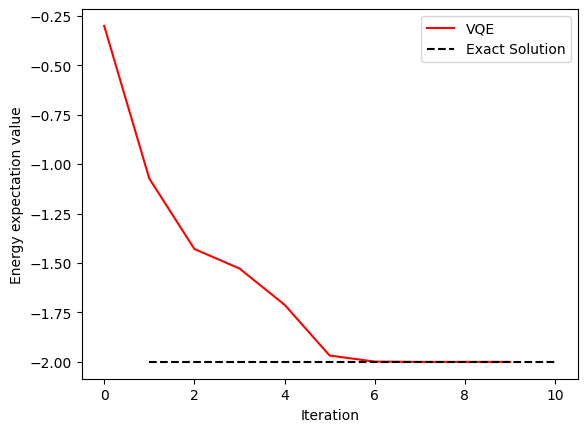

In [56]:
import PyPlot
PyPlot.plot(cost_history, color="red", label="VQE")
PyPlot.plot(1:length(cost_history), fill(EigVal_min, length(cost_history)),
    linestyle="dashed", color="black", label="Exact Solution")
PyPlot.xlabel("Iteration")
PyPlot.ylabel("Energy expectation value")
PyPlot.legend()
PyPlot.show()

In [14]:
divide_real_imag_openfermion(op) = 
    (op+of.utils.hermitian_conjugated(op))/2, (op-of.utils.hermitian_conjugated(op))/2im

function make_rdm1(state, n_qubit)
    one_rdm = zeros(Complex{Float64}, n_qubit, n_qubit)
    for p in 1:n_qubit, q in 1:n_qubit
        jw_hamiltonian = jordan_wigner(of.ops.FermionOperator(((p-1, 1), (q-1, 0))))
        her, antiher = divide_real_imag_openfermion(jw_hamiltonian)
        qulacs_hamiltonian_real = convert_openfermion_op(n_qubit, her)
        qulacs_hamiltonian_imag = convert_openfermion_op(n_qubit, antiher)
        pq_one_rdm_real = qulacs_hamiltonian_real.get_expectation_value(state)
        pq_one_rdm_imag = qulacs_hamiltonian_imag.get_expectation_value(state)
        one_rdm[p, q] = pq_one_rdm_real + pq_one_rdm_imag * im
    end
    one_rdm
end

make_rdm1 (generic function with 1 method)

## 縮約密度行列の計算法
以下のコードブロックでは、VQE波動関数から１次の縮約密度行列
$$
\gamma_{pq} =
\langle \Psi |
a^{\dagger}_p a_q
|\Psi \rangle 
$$
を計算する方法を示す。

In [15]:
import LinearAlgebra

state = qulacs.QuantumState(n_qubit) 
state.set_computational_basis(hfstate(n_qubit, n_electron))# Hartree-Fock State
rdm_hf = make_rdm1(state, n_qubit)
println("RDM of HF")
println(rdm_hf)
println("Number of electrons (HF)")
println(real(LinearAlgebra.tr(rdm_hf)))

circuit.update_quantum_state(state) #量子回路を状態に作用
rdm_uccsd = make_rdm1(state, n_qubit)
println("RDM of UCCSD")
println(rdm_uccsd)
println("Number of electrons (UCCSD)")
println(real(LinearAlgebra.tr(rdm_hf)))    

RDM of HF
Complex{Float64}[1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im]
Number of electrons (HF)
1.0
RDM of UCCSD
Complex{Float64}[1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im]
Number of electrons (UCCSD)
1.0
